In [47]:
# Updates March 15, 2025
# from google.colab import files
# uploaded = files.upload()

In [48]:
#  import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [49]:
file_path = os.path.join("data", "diabetes_prediction_dataset.csv")
df = pd.read_csv(file_path)
# df = pd.read_csv("data/diabetes_prediction_dataset.csv")
# df = pd.read_csv("C:/Users/USSB697670/Desktop/GeorgiaTech/Data_Visual_Analytics/Project/diabetes_prediction_dataset.csv")
print(df.info())
print(df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None
(100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# Exploratory Data Analysis

In [50]:
# df.describe()
# df.info()

Checking missing value

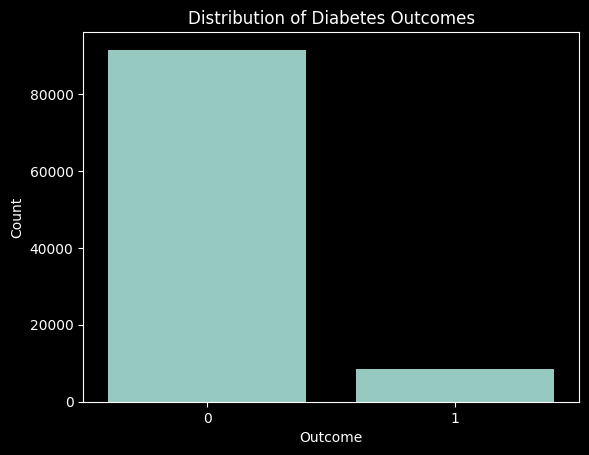

In [51]:
# print(df.isnull().sum())
sns.countplot(x=df['diabetes'], data=df)
plt.title('Distribution of Diabetes Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

Label Encoder

**Review the categorical variables**
 - **if needed, we will use label encoding**

In [52]:
# Check unique values for 'gender'
print("Unique values in 'gender':", df['gender'].unique())

# Check unique values for 'smoking_history'
print("Unique values in 'smoking_history':", df['smoking_history'].unique())


Unique values in 'gender': ['Female' 'Male' 'Other']
Unique values in 'smoking_history': ['never' 'No Info' 'current' 'former' 'ever' 'not current']


**Since Gender has 3 values, we can keep the Label encoding as-is**
**However, smoking_history has 6 values, so we will use one-hot encoding**


In [53]:
# encode the data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
# #df['smoking_history'] = le.fit_transform(df['smoking_history'])
# # One-Hot Encode 'smoking_history' (since it has multiple unordered categories)
# df = pd.get_dummies(df, columns=['smoking_history'], drop_first=True)

# # Display updated column names
# print("Updated Columns after Encoding:", df.columns)

In [54]:
# Implementing Target Encoding for 'smoking_history'
# Assuming the dataset contains a binary target variable 'diabetes'

# Calculate mean diabetes rate per smoking category (Target Encoding)
df['smoking_encoded'] = df.groupby('smoking_history')['diabetes'].transform('mean')

# Drop original smoking_history columns after target encoding
df.drop(columns=[col for col in df.columns if 'smoking_history' in col], inplace=True)

# Display updated column names after encoding
print("Updated Columns after Encoding:", df.columns)

# Display first few rows to verify encoding
display(df.head())

Updated Columns after Encoding: Index(['gender', 'age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes', 'smoking_encoded'],
      dtype='object')


,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded
0,0,80.0,0,1,25.19,6.6,140,0,0.095341
1,0,54.0,0,0,27.32,6.6,80,0,0.040596
2,1,28.0,0,0,27.32,5.7,158,0,0.095341
3,0,36.0,0,0,23.45,5.0,155,0,0.102089
4,1,76.0,1,1,20.14,4.8,155,0,0.102089


In [55]:
df

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded
0,0,80.0,0,1,25.19,6.6,140,0,0.095341
1,0,54.0,0,0,27.32,6.6,80,0,0.040596
2,1,28.0,0,0,27.32,5.7,158,0,0.095341
3,0,36.0,0,0,23.45,5.0,155,0,0.102089
4,1,76.0,1,1,20.14,4.8,155,0,0.102089
...,...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,27.32,6.2,90,0,0.040596
99996,0,2.0,0,0,17.37,6.5,100,0,0.040596
99997,1,66.0,0,0,27.83,5.7,155,0,0.170017
99998,0,24.0,0,0,35.42,4.0,100,0,0.095341


In [56]:
import sqlite3

# Connect to SQLite database (creates if it doesn’t exist)
conn = sqlite3.connect("diabetes_results.db")
cursor = conn.cursor()

# Drop the existing table (WARNING: This will delete all previous results)
cursor.execute("DROP TABLE IF EXISTS model_results")


# Create table for storing model results
cursor.execute("""
    CREATE TABLE IF NOT EXISTS model_results (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        model_name TEXT,
        threshold REAL,
        precision REAL,
        recall REAL,
        f1_score REAL,
        accuracy REAL,
        run_timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
    )
""")
conn.commit()
conn.close()


In [57]:
import sqlite3
from sklearn.metrics import classification_report

def store_classification_results(model_name, threshold, y_true, y_pred):
    """Extract classification metrics and store them in SQLite"""
    
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Extract key metrics
    precision = report["1"]["precision"]
    recall = report["1"]["recall"]
    f1_score = report["1"]["f1-score"]
    accuracy = report["accuracy"]
    
    # Store in SQLite database
    conn = sqlite3.connect("diabetes_results.db")
    cursor = conn.cursor()

    # Check if this model run already exists
    cursor.execute("""
        SELECT COUNT(*) FROM model_results
        WHERE model_name = ? AND threshold = ? AND precision = ? AND recall = ? AND accuracy = ?
    """, (model_name, threshold, precision, recall, accuracy))

    cursor.execute("""
        INSERT INTO model_results (model_name, threshold, precision, recall, f1_score, accuracy)
        VALUES (?, ?, ?, ?, ?, ?)
    """, (model_name, threshold, precision, recall, f1_score, accuracy))
    
    conn.commit()
    conn.close()
    
    print(f"Results stored successfully: {model_name} (Threshold: {threshold})")



# Feature Importance

In [58]:
# x = df.drop("diabetes",axis=1)
# y = df["diabetes"]
# from sklearn.ensemble import ExtraTreesClassifier
# import matplotlib.pyplot as plt
# model = ExtraTreesClassifier()
# model.fit(x,y)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=x.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

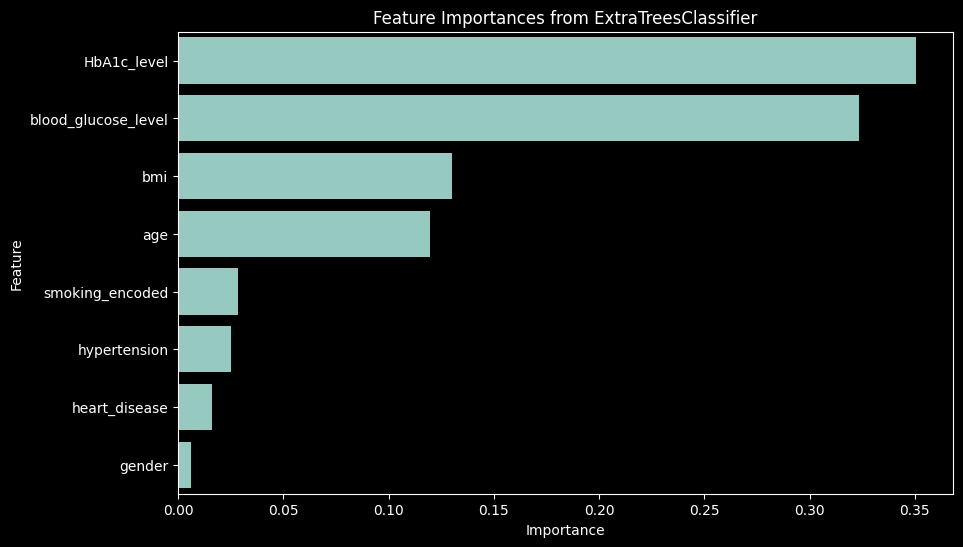

In [59]:
from sklearn.ensemble import ExtraTreesClassifier

# Define Features and Target variables
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Train ExtraTreesClassifier to identify feature importance
model = ExtraTreesClassifier()
model.fit(X, y)
# Get feature importances
importances = model.feature_importances_
# Create a DataFrame for better visualization
feat_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
# Sort the DataFrame by importance
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)
# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances)
plt.title('Feature Importances from ExtraTreesClassifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Feature Selection**

In [60]:
# Keep all features for visualization & dashboard interaction
X_full = df.drop(columns=["diabetes"])  # Keeps everything except the target variable

# Optimized feature set (for model training)
selected_features = ["HbA1c_level", "blood_glucose_level", "bmi", "age", "hypertension", "heart_disease", "smoking_encoded"]
X_selected = df[selected_features]

# Target variable remains the same
y = df["diabetes"]


Splitting Data


In [61]:
# We use StratifiedFold so that each fold in x-validation has the same proportion of diabetic and non-diabetic cases as the original dataset. 
# Also ensure balanced class distribution in each fold.
# Also find the best parameters while preventing overfitting
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Model Selection

1. Logistic Regression

In [62]:
# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# # Define features and target
# X = df.drop(columns=["diabetes"])  # Ensure "diabetes" is the correct target column name
# y = df["diabetes"]

# Apply StandardScaler BEFORE train-test split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)  

# Step 1. Split the data into training and testing sets (80% train, 20% test)

# X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=selected_features)  # Ensure you have the correct feature names

if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=selected_features)



# # Initialize and train the model
# model = LogisticRegression()
# model.fit(X_train, y_train)

In [63]:
# Step 2. Use only selected features for model training
#selected_features = ["HbA1c_level", "blood_glucose_level", "bmi", "age", "hypertension", "heart_disease"]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Step 3. Train the model with selected features
model_lr = LogisticRegression()
model_lr.fit(X_train_selected, y_train)

# Step 4: Evaluate and make predictions on the new model
y_preds_selected_lr = model_lr.predict(X_test_selected)
store_classification_results("Logistic Regression", 0.50, y_test, y_preds_selected_lr)

print("Model Performance with Selected Features:")
print(classification_report(y_test, y_preds_selected_lr))


Results stored successfully: Logistic Regression (Threshold: 0.5)
Model Performance with Selected Features:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.86      0.64      0.73      1700

    accuracy                           0.96     20000
   macro avg       0.91      0.81      0.85     20000
weighted avg       0.96      0.96      0.96     20000



**Summary**
    - **Model Accuracy is at 96%**  
    - **When the model predicts diabetes, it is correct 86% of the time**    
    - **However, the model only catches 64% of actual diabetes cases**   
    - **Balanced performance based on f1-score 0.73**   

**Concerns**    
    - **We are missing 36% of the actual diabetic cases**   

Check class distribution

diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64


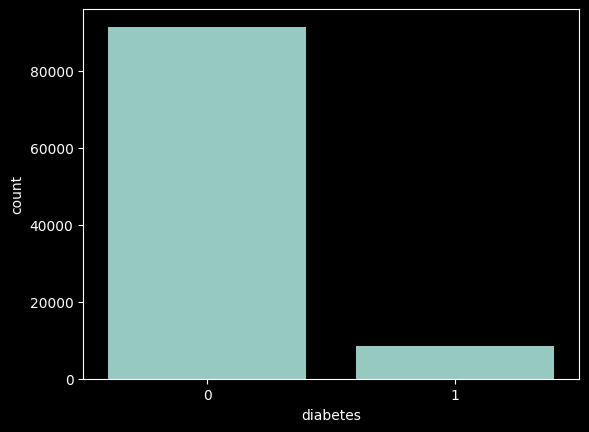

In [64]:
import seaborn as sns

sns.countplot(x=y)
print(y.value_counts(normalize=True))  # Shows class proportions


Handling class imbalance as the Model is predicting majority as 0 meaning "no diabetes"


**Test SMOTE with new threshold 0.85**

In [65]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

# Train Logistic Regression Again
model_smote = LogisticRegression()
model_smote.fit(X_train_balanced, y_train_balanced)

# Predict & Evaluate
y_preds_smote = model_smote.predict(X_test_selected)
store_classification_results("Logistic Regression (SMOTE)", 0.50, y_test, y_preds_smote)
print("Model Performance after SMOTE:")
print(classification_report(y_test, y_preds_smote))


Results stored successfully: Logistic Regression (SMOTE) (Threshold: 0.5)
Model Performance after SMOTE:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     18300
           1       0.55      0.82      0.66      1700

    accuracy                           0.93     20000
   macro avg       0.77      0.88      0.81     20000
weighted avg       0.95      0.93      0.93     20000



**Summary of Model performance after applying SMOTE**
    - **Model Accuracy dropped to 92%**  
    - **When the model predicts diabetes, it is correct 53% of the time**    
    - **However, the model now catches 80% of actual diabetes cases**   
    - **Balanced performance based on f1-score 0.64**   

**We are now only missing 20% of the actual diabetic cases**   

In [66]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Compute class weight ratio for handling imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Train XGBoost with class balancing
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train_selected, y_train)

# Predict on test set
y_preds_xgb = xgb_model.predict(X_test_selected)

# Evaluate model performance
store_classification_results("XGBoost (Default threshold 50)", 0.50, y_test, y_preds_selected_lr)

print("XGBoost Model Performance:")
print(classification_report(y_test, y_preds_xgb))


Results stored successfully: XGBoost (Default threshold 50) (Threshold: 0.5)
XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     18300
           1       0.52      0.88      0.65      1700

    accuracy                           0.92     20000
   macro avg       0.75      0.90      0.80     20000
weighted avg       0.95      0.92      0.93     20000



In [67]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_probs_xgb = xgb_model.predict_proba(X_test_selected)[:, 1]

# Adjust threshold (default = 0.50)
new_threshold = 0.40
y_preds_xgb_tuned = (y_probs_xgb >= new_threshold).astype(int)

# Evaluate performance with adjusted threshold

store_classification_results("iXGBoost (Tuned threshold 40)", 0.40, y_test, y_preds_selected_lr)


print("XGBoost Performance with Adjusted Threshold (0.40):")
print(classification_report(y_test, y_preds_xgb_tuned))


Results stored successfully: iXGBoost (Tuned threshold 40) (Threshold: 0.4)
XGBoost Performance with Adjusted Threshold (0.40):
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     18300
           1       0.45      0.92      0.61      1700

    accuracy                           0.90     20000
   macro avg       0.72      0.91      0.77     20000
weighted avg       0.95      0.90      0.91     20000



In [68]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_probs_xgb = xgb_model.predict_proba(X_test_selected)[:, 1]

# Adjust threshold (default = 0.50)
new_threshold = 0.50
y_preds_xgb_tuned = (y_probs_xgb >= new_threshold).astype(int)

# Evaluate performance with adjusted threshold
print("XGBoost Performance with Adjusted Threshold (0.50):")
print(classification_report(y_test, y_preds_xgb_tuned))

XGBoost Performance with Adjusted Threshold (0.50):
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     18300
           1       0.52      0.88      0.65      1700

    accuracy                           0.92     20000
   macro avg       0.75      0.90      0.80     20000
weighted avg       0.95      0.92      0.93     20000



**Train XGBoost Classifier to handle imbalanced datasets**
**We are exoecting better performance with XGBoost than Logistic Regression**

In [69]:
from sklearn.metrics import classification_report
import pandas as pd

# Capture classification report for Logistic Regression with SMOTE
report_smote = classification_report(y_test, y_preds_smote, output_dict=True)

# Capture classification report for XGBoost with tuned threshold
report_xgb_tuned = classification_report(y_test, y_preds_xgb_tuned, output_dict=True)

# Convert reports to DataFrames
df_smote = pd.DataFrame(report_smote).transpose()
df_xgb_tuned = pd.DataFrame(report_xgb_tuned).transpose()

# Combine the two reports for side-by-side comparison
comparison_table = pd.concat([df_smote.add_suffix('_SMOTE'), df_xgb_tuned.add_suffix('_XGB_Tuned')], axis=1)

# Display the comparison table
print(comparison_table)

              precision_SMOTE  recall_SMOTE  f1-score_SMOTE  support_SMOTE  \
0                    0.982211      0.938361        0.959785    18300.00000   
1                    0.551847      0.817059        0.658762     1700.00000   
accuracy             0.928050      0.928050        0.928050        0.92805   
macro avg            0.767029      0.877710        0.809274    20000.00000   
weighted avg         0.945630      0.928050        0.934198    20000.00000   

              precision_XGB_Tuned  recall_XGB_Tuned  f1-score_XGB_Tuned  \
0                        0.988186          0.923279            0.954630   
1                        0.516196          0.881176            0.651021   
accuracy                 0.919700          0.919700            0.919700   
macro avg                0.752191          0.902228            0.802826   
weighted avg             0.948067          0.919700            0.928823   

              support_XGB_Tuned  
0                    18300.0000  
1           

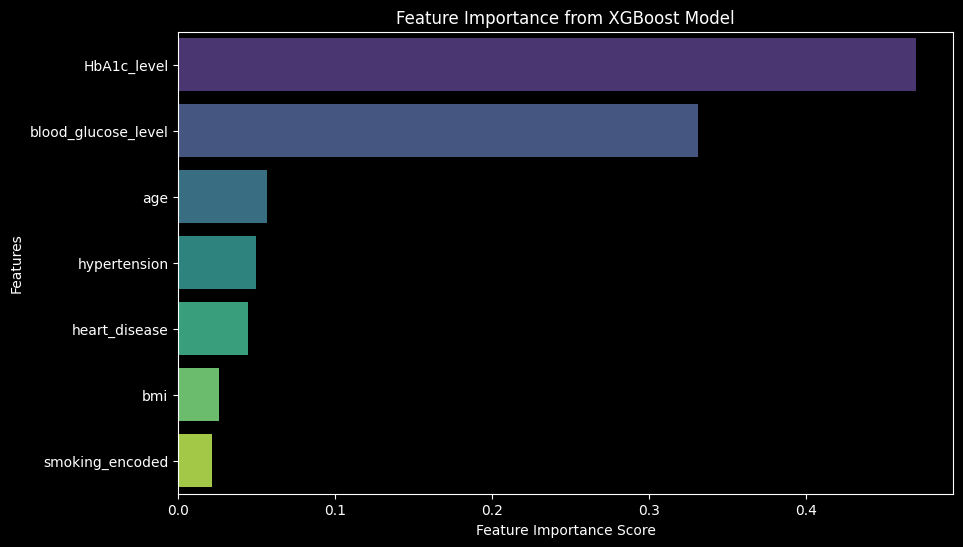

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from trained XGBoost model
feature_importances = xgb_model.feature_importances_
feature_names = X_train_selected.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette='viridis')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from XGBoost Model")
plt.show()


# **TESTING**
 - **Include all unit testing below**


In [71]:
df.describe

<bound method NDFrame.describe of        gender   age  hypertension  heart_disease    bmi  HbA1c_level  \
0           0  80.0             0              1  25.19          6.6   
1           0  54.0             0              0  27.32          6.6   
2           1  28.0             0              0  27.32          5.7   
3           0  36.0             0              0  23.45          5.0   
4           1  76.0             1              1  20.14          4.8   
...       ...   ...           ...            ...    ...          ...   
99995       0  80.0             0              0  27.32          6.2   
99996       0   2.0             0              0  17.37          6.5   
99997       1  66.0             0              0  27.83          5.7   
99998       0  24.0             0              0  35.42          4.0   
99999       0  57.0             0              0  22.43          6.6   

       blood_glucose_level  diabetes  smoking_encoded  
0                      140         0         

In [72]:
df.info

<bound method DataFrame.info of        gender   age  hypertension  heart_disease    bmi  HbA1c_level  \
0           0  80.0             0              1  25.19          6.6   
1           0  54.0             0              0  27.32          6.6   
2           1  28.0             0              0  27.32          5.7   
3           0  36.0             0              0  23.45          5.0   
4           1  76.0             1              1  20.14          4.8   
...       ...   ...           ...            ...    ...          ...   
99995       0  80.0             0              0  27.32          6.2   
99996       0   2.0             0              0  17.37          6.5   
99997       1  66.0             0              0  27.83          5.7   
99998       0  24.0             0              0  35.42          4.0   
99999       0  57.0             0              0  22.43          6.6   

       blood_glucose_level  diabetes  smoking_encoded  
0                      140         0         0.

In [73]:
import pandas as pd

# Load stored results into a DataFrame
conn = sqlite3.connect("diabetes_results.db")
df_results = pd.read_sql("SELECT * FROM model_results", conn)
conn.close()

# Display results
print(df_results)


   id                      model_name  threshold  precision    recall  \
0   1             Logistic Regression        0.5   0.861244  0.635294   
1   2     Logistic Regression (SMOTE)        0.5   0.551847  0.817059   
2   3  XGBoost (Default threshold 50)        0.5   0.861244  0.635294   
3   4   iXGBoost (Tuned threshold 40)        0.4   0.861244  0.635294   

   f1_score  accuracy        run_timestamp  
0  0.731212   0.96030  2025-03-20 02:17:04  
1  0.658762   0.92805  2025-03-20 02:17:05  
2  0.731212   0.96030  2025-03-20 02:17:15  
3  0.731212   0.96030  2025-03-20 02:17:15  


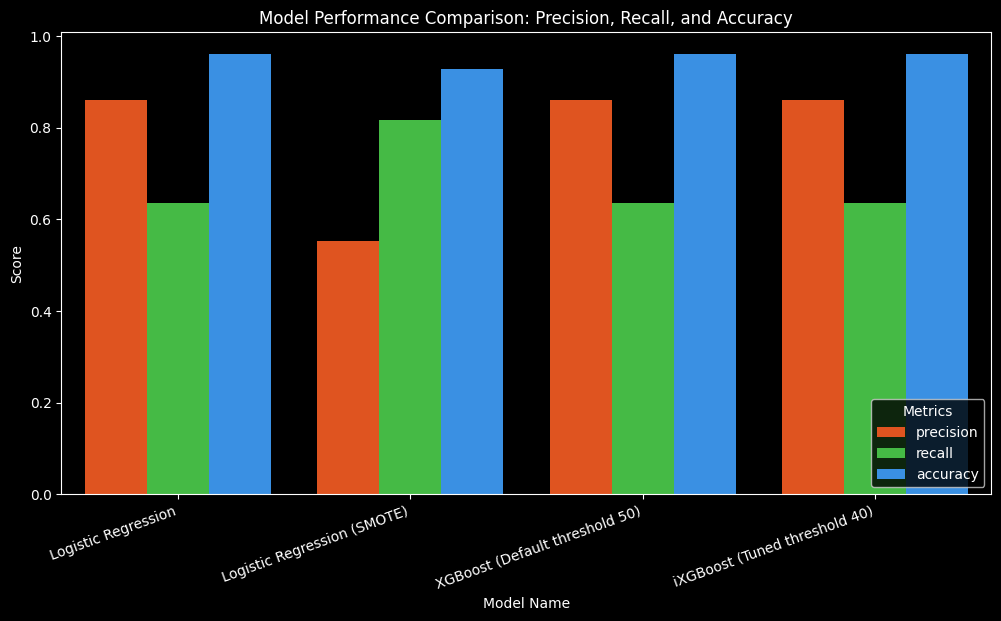

In [74]:
# Re-import necessary libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load stored results into a DataFrame
conn = sqlite3.connect("diabetes_results.db")
df_results = pd.read_sql("SELECT * FROM model_results", conn)
conn.close()

# Set dark plot style
plt.style.use("dark_background")

# Set figure size
plt.figure(figsize=(12, 6))

# Reshape DataFrame for seaborn compatibility
df_melted = df_results.melt(id_vars='model_name', value_vars=['precision', 'recall', 'accuracy'],
                            var_name='metric', value_name='score')

# Define brighter colors explicitly
palette = {"precision": "#FF4500", "recall": "#32CD32", "accuracy": "#1E90FF"}

# Create grouped bar plot
sns.barplot(data=df_melted, x="model_name", y="score", hue="metric", palette=palette)

# Customize the plot
plt.xlabel("Model Name")
plt.ylabel("Score")
plt.xticks(rotation=20, ha="right")
plt.title("Model Performance Comparison: Precision, Recall, and Accuracy")
plt.legend(title='Metrics', loc='lower right')


# Show plot
plt.show()


**Legend**  
    -   **precision: higher the precision, the fewer the false alarms**     
    -   **recall: higher the recall, the model accurately identifies who are diabetic**    